In [656]:
from __future__ import annotations
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

%matplotlib inline

In [657]:
words: list[str] = open("names.txt", "r").read().splitlines()

In [658]:
# Gets all the characters, a-z
chars: list[str] = sorted(list(set("".join(words))))

# Maps each character to an integer
stoi: dict[str, int] = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0

# Maps each integer to a character
itos: dict[int, str] = {i: s for s, i in stoi.items()}

In [659]:
# Build dataset
def build_dataset(words: list[str], print_examples: int = 0) -> tuple[torch.Tensor, torch.Tensor]:
    block_size = 3 # Context length: number of characters taken to predict the next one
    X, Y = [], []
    for i, w in enumerate(words):
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            if i < print_examples:
                print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]
    
    return torch.tensor(X), torch.tensor(Y)

In [660]:
X, Y = build_dataset(words, 5)

... ----> e
..e ----> m
.em ----> m
emm ----> a
mma ----> .
... ----> o
..o ----> l
.ol ----> i
oli ----> v
liv ----> i
ivi ----> a
via ----> .
... ----> a
..a ----> v
.av ----> a
ava ----> .
... ----> i
..i ----> s
.is ----> a
isa ----> b
sab ----> e
abe ----> l
bel ----> l
ell ----> a
lla ----> .
... ----> s
..s ----> o
.so ----> p
sop ----> h
oph ----> i
phi ----> a
hia ----> .


In [661]:
X.shape, Y.shape, X.dtype, Y.dtype

(torch.Size([228146, 3]), torch.Size([228146]), torch.int64, torch.int64)

In [662]:
# Embedding lookup table
C = torch.randn((27, 2))

In [663]:
# Parameters
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [664]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [665]:
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters) # Number of parameters in total

3481

In [666]:
# Forward pass
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [667]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
print(h)
h.shape

tensor([[-1.0000, -0.9712, -0.9961,  ...,  0.9114, -0.9987, -0.9156],
        [-1.0000, -0.9996,  0.6872,  ...,  0.8968,  0.9974, -0.9889],
        [-0.9995, -0.8413,  1.0000,  ...,  0.0588,  0.8484,  0.3715],
        ...,
        [-0.9991,  0.1407,  0.9351,  ...,  0.9997, -0.9999, -0.9404],
        [-0.9999, -0.9989,  0.7465,  ...,  1.0000,  0.8867, -0.9999],
        [ 1.0000,  0.9793,  0.8449,  ..., -0.8206, -1.0000, -0.9935]])


torch.Size([228146, 100])

In [668]:
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [669]:
counts = logits.exp()
prob = counts / counts.sum(-1, keepdim=True)
prob.shape

torch.Size([228146, 27])

In [670]:
loss = -prob[torch.arange(len(Y)), Y].log().mean()
loss

tensor(12.8877)

In [671]:
loss = F.cross_entropy(logits, Y)
loss

tensor(12.8877)

In [672]:
for p in parameters:
    p.requires_grad = True

In [673]:
# Learning rate
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [674]:
# Find optimal learning rate
lri = []
lossi = []

for i in range(1000):
    # Minibatch construct
    ix = torch.randint(0, X.shape[0], (32, ))

    # Forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    lri.append(lre[i])
    lossi.append(loss.item())

print(loss.item())

5.64719820022583


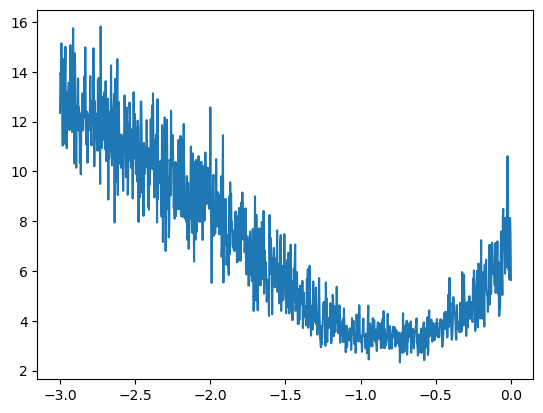

In [675]:
plt.plot(lri, lossi)

In [676]:
# Training
for i in range(10000):
    # Minibatch construct
    ix = torch.randint(0, X.shape[0], (32, ))

    # Forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

print(loss.item())

2.7681806087493896


In [677]:
# Create the data sets
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# Training split (80%)
Xtr, Ytr = build_dataset(words[:n1])

# Dev/validation split (10%)
Xdev, Ydev = build_dataset(words[n1:n2])

# Test split (10%)
Xte, Yte = build_dataset(words[n2:])

In [678]:
# Parameters
C = torch.randn((27, 2))
W1 = torch.randn((6, 300))
b1 = torch.randn(300)
W2 = torch.randn((300, 27))
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [679]:
lossi = []
stepi = []

# Training
for i in range(30000):
    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32, ))

    # Forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    stepi.append(i)
    lossi.append(loss.item())

print(loss.item())

2.5178844928741455


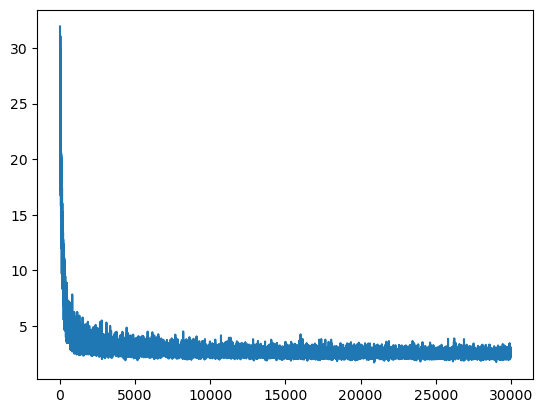

In [680]:
plt.plot(stepi, lossi)

In [681]:
# Evaluate training
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.495684862136841


In [682]:
# Evaluate dev
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.509204149246216


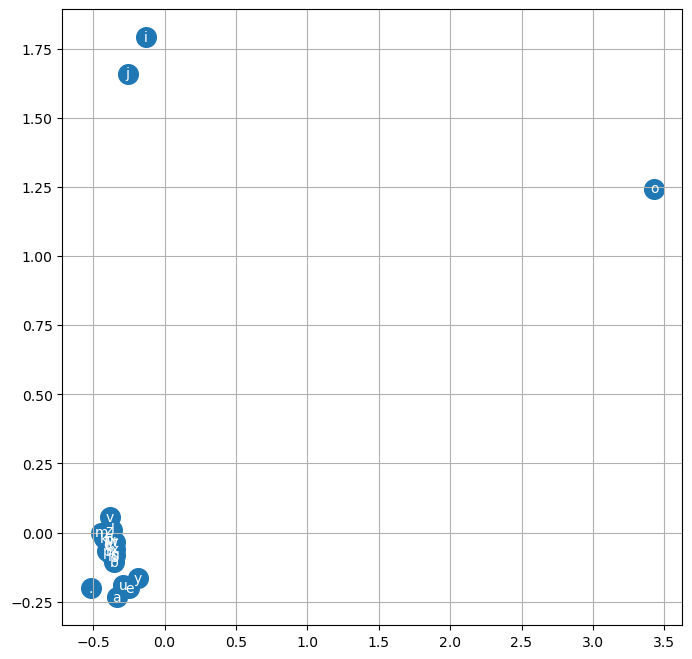

In [683]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")